In [9]:
#setting up
%run import-xgboost.py #calls script to build xgboost path variables for windows on my machine

#libraries used
import xgboost as xgb #modeling
import pandas as pd #dataframe manipulation
import numpy as np  #n-arrays
from sklearn.metrics import accuracy_score #scoring

import matplotlib.pyplot as plt #plotting graphs
import seaborn as sns  #for better looking graphs

%matplotlib inline

np.random.seed(0) #For repeatability of the experiment

target = 'survival_7_years'
idcolumn = 'id'

This data set was part of a data compteition. Since I can't disclose the data (NDA and all that), I have edited out the data exploration steps.
With the data all set up, we move on to the modelling. I used gradient boosting, using the xgboost package. <br/>
The focus here is to <b>understand</b> how to change model parameters based on the values of train and test error you see.
Hence I hand-tuned parameters to improve the performance, instead of simply running a GridSearch.

XGboost has a LOT of paramters. For an understanding of what these are, check out this <a , href="https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/" > Complete Guide by AnalyticsVidya  </a>

In [51]:
#building and tuning the Xgboost model
from sklearn.metrics import confusion_matrix

#Creating the DMatrix from the training data set
xgtrain = xgb.DMatrix(final_train[cols_to_use], label=final_train[target])

#Setting the hyper-parameters for the model
cv_folds =5 
early_stopping_rounds = 50

#initial model- started with a high variance 
xgb1 = xgb.XGBClassifier(
 learning_rate =0.01,
 n_estimators=100,
 max_depth=10,
 subsample=0.9,
 seed=1)

#Decreasing subsample and max_depth to reduce overfit
xgb2 = xgb.XGBClassifier(
 learning_rate =0.01,
 n_estimators=100, 
 max_depth=8,
 subsample=0.8,
 seed=1)

#Decreasing subsample and max_depth to further reduce overfit
xgb3 = xgb.XGBClassifier(
 learning_rate =0.01,
 n_estimators=100,
 max_depth=6,
 subsample=0.6,
 seed=1)

#inititalize the model for cross validation
xgbmodel=xgb3
#perform cross validation 
cvresult = xgb.cv(xgbmodel.get_xgb_params(), xgtrain, num_boost_round=xgbmodel.get_params()['n_estimators'], nfold=cv_folds,
                      metrics = ['error'], early_stopping_rounds=early_stopping_rounds, verbose_eval=False)
xgbmodel.set_params(n_estimators=cvresult.shape[0]) 
best_round = cvresult.shape[0] -1
print(cvresult.tail())


    test-error-mean  test-error-std  train-error-mean  train-error-std
32         0.341372        0.007914          0.323286         0.001566
33         0.341047        0.007828          0.323156         0.001760
34         0.341307        0.008122          0.323334         0.001432
35         0.340787        0.008300          0.323334         0.001108
36         0.340722        0.008130          0.323480         0.001301


For any model, error can be decomposed into the following terms -
Error = ErrorBias + ErrorVariance+ (Errornoise)
I started with a low bias tree, with an aim of improving its variance. I used the depth of the tree and the subsample percentage to control the overfit.  
1.	I started with a subsampling ratio of 0.9 and grew a deep tree with max_depth = 10. I chose 10 to satisfy the rule of thumb that each leaf node should have 1% of the data. That indicates 15 terminal nodes, which would mean a depth of 4 for a binary tree. Hence 10 would be a deep tree for our data set. With this depth, and subsampling I got very good results for train, but bad for test. This indicates an overfit, which is what was expected. 
<b>Test-error: 0.350991, Training-error: 0.211976 </b>
2.	I reduced max_depth to 8 and decreased subsampling to 0.8 with the aim of reducing overfit. This showed some improvement on the test, indicating I was closer to the best model. 
<b>Test-error: 0.345271, Training-error: 0.293663</b>
3.	At max_depth of 6, and subsampling of .6, I saw the test error drop significantly and the train error train very close to the test error. For this iteration, the cross validation stopped at the 36th tree. 
<b>Test-error: 0.340722, Training-error: 0.323480</b>

This is exactly what I was aiming for- a reliable model with low bias, which doesn’t overfit!

I ran one more iteration with max_depth as 5 to be sure. As expected, it increased my test error and reduced my training error. Thus, I conclude the best parameters for my model are from iteration #3. With these model parameters, I fit the model on the training set and calculate prediction accuracy as given 7-year survival values compared to those predicted (default probability threshold of 0.5). 
It gave a training accuracy of 67.53% which is much better than the baseline! (The basline was 57%) 


In [52]:
#Evaluating the model 
#Fit the selected model on the training data
xgbmodel.fit(final_train[cols_to_use], final_train[target],eval_metric="error")

#Predict the dependent variable
y_pred = xgbmodel.predict(final_train[cols_to_use])
class_predictions = [round(value) for value in y_pred] #use default threhold of 0.5

#Print model accuracy
print ( "Train Accuracy : %.4f" % accuracy_score(final_train[target], class_predictions))        

Train Accuracy : 0.6753


In [53]:
#Check the confusion matrix
from sklearn.metrics import classification_report
print(classification_report(final_train[target], class_predictions) )

             precision    recall  f1-score   support

        0.0       0.72      0.71      0.71      8734
        1.0       0.62      0.63      0.63      6651

avg / total       0.68      0.68      0.68     15385



We observe a ~68% accuracy! That is much better than our 53% baseline! <br/>  Let's look at the feature importances before we predict the survival values on the scoring data

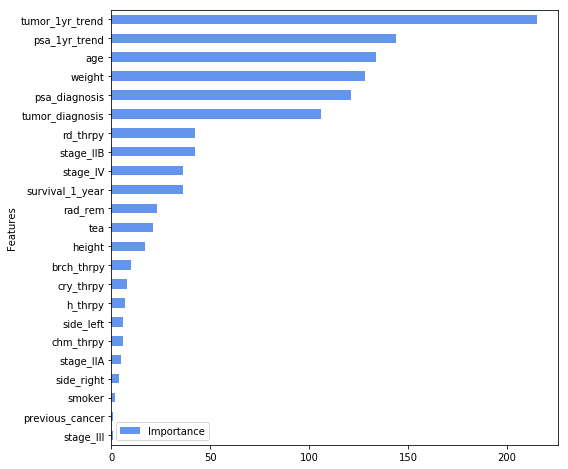

In [54]:
#Feature importance 
best_model = xgb.train(xgb3.get_xgb_params(), xgtrain, best_round)
importances = best_model.get_fscore()
imp_frame = pd.DataFrame({'Importance': list(importances.values()), 'Features': list(importances.keys())})
imp_frame.sort_values(by = 'Importance', inplace = True)
imp_frame.plot(kind = 'barh', x = 'Features', figsize = (8,8), color = 'cornflowerblue')
plt.show()

As we see from the variable importance graph, the 1 year trend variables that we created, are both extremely useful for the model!<br/>
In addition, the age and wieght of the patient are also used.
